<a href="https://colab.research.google.com/github/likevin9911/Machine-Learning-Projects/blob/main/Numpy_Double_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.datasets import mnist
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Simple Neural Networks/mnist_test.csv')

In [ ]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Extract features and labels
x = data.iloc[:, 1:].values #features
y = data.iloc[:, 0 ].values #label

# randomization
shuffled_indices = np.random.permutation(len(data))
x = x[shuffled_indices]
y = y[shuffled_indices]

# split into 80/20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# normalize 0:255 grayscale
x_train = x_train / 255
x_test = x_test / 255


In [ ]:
# Deep Learning initialization techniques
  # def xavier_init(size):
  #   in_dim, out_dim = size
  #   xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
  #   return np.random.randn(out_dim, in_dim) * xavier_stddev

  # def he_init(size):
  #   in_dim, out_dim = size
  #   he_stddev = np.sqrt(2 / in_dim)
  #   return np.random.randn(out_dim, in_dim) * he_stddev

# Determine the dimensions
input_dim = x_train.shape[1]
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = len(np.unique(y_train))
init_range = 1

# Uniform Initialization
w1 = np.random.uniform(-init_range, init_range, (hidden_dim1, input_dim))
b1 = np.zeros((hidden_dim1, 1))
w2 = np.random.uniform(-init_range, init_range, (hidden_dim2, hidden_dim1))
b2 = np.zeros((hidden_dim2, 1))
w3 = np.random.uniform(-init_range, init_range, (output_dim, hidden_dim2))
b3 = np.zeros((output_dim, 1))

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(z):
    return np.maximum(z, 0)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

# Forward propagation
def forward_prop(x, w1, b1, w2, b2, w3, b3):
    z1 = w1.dot(x) + b1
    a1 = ReLU(z1)  # Changed activation function to ReLU
    z2 = w2.dot(a1) + b2
    a2 = ReLU(z2)  # Added second hidden layer with ReLU
    z3 = w3.dot(a2) + b3
    a3 = softmax(z3)
    return z1, a1, z2, a2, z3, a3

# Derivatives
def deriv_ReLU(z):
    return z > 0

def one_hot(y, num_classes):
    one_hot_y = np.zeros((y.size, num_classes))
    one_hot_y[np.arange(y.size), y] = 1
    return one_hot_y.T

# Backward propagation
def back_prop(x, y, z1, a1, z2, a2, z3, a3, w1, w2, w3, l2_lambda):
    m = y.size
    one_hot_y = one_hot(y, a3.shape[0])
    dz3 = a3 - one_hot_y
    dw3 = 1 / m * dz3.dot(a2.T) + (l2_lambda / m) * w3
    db3 = 1 / m * np.sum(dz3, axis=1, keepdims=True)
    da2 = w3.T.dot(dz3)
    dz2 = da2 * deriv_ReLU(z2)
    dw2 = 1 / m * dz2.dot(a1.T) + (l2_lambda / m) * w2
    db2 = 1 / m * np.sum(dz2, axis=1, keepdims=True)
    da1 = w2.T.dot(dz2)
    dz1 = da1 * deriv_ReLU(z1)
    dw1 = 1 / m * dz1.dot(x.T) + (l2_lambda / m) * w1
    db1 = 1 / m * np.sum(dz1, axis=1, keepdims=True)
    return dw1, db1, dw2, db2, dw3, db3

# Update parameters
def update_params(params, grads, learning_rate):
    for key in params.keys():
        params[key] -= learning_rate * grads[key]

# Compute loss
def compute_loss(a3, y, w1, w2, w3, l2_lambda):
    m = y.size
    one_hot_y = one_hot(y, a3.shape[0])
    log_probs = -np.log(a3[one_hot_y == 1])
    data_loss = np.sum(log_probs) / m
    l2_loss = l2_lambda / (2 * m) * (np.sum(np.square(w1)) + np.sum(np.square(w2)) + np.sum(np.square(w3)))
    return data_loss + l2_loss

# Train model
def train_model(x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate, l2_lambda):
    num_classes = len(np.unique(y_train))
    params = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2, 'w3': w3, 'b3': b3}
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        permutation = np.random.permutation(x_train.shape[0])
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train_shuffled[i:i+batch_size].T
            y_batch = y_train_shuffled[i:i+batch_size]

            z1, a1, z2, a2, z3, a3 = forward_prop(x_batch, params['w1'], params['b1'], params['w2'], params['b2'], params['w3'], params['b3'])
            dw1, db1, dw2, db2, dw3, db3 = back_prop(x_batch, y_batch, z1, a1, z2, a2, z3, a3, params['w1'], params['w2'], params['w3'], l2_lambda)
            grads = {'w1': dw1, 'b1': db1, 'w2': dw2, 'b2': db2, 'w3': dw3, 'b3': db3}
            update_params(params, grads, learning_rate)

        # Training metrics
        z1, a1, z2, a2, z3, a3 = forward_prop(x_train.T, params['w1'], params['b1'], params['w2'], params['b2'], params['w3'], params['b3'])
        train_predictions = np.argmax(a3, axis=0)
        train_accuracy = np.mean(train_predictions == y_train)
        train_loss = compute_loss(a3, y_train, params['w1'], params['w2'], params['w3'], l2_lambda)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        # Validation metrics
        z1, a1, z2, a2, z3, a3 = forward_prop(x_test.T, params['w1'], params['b1'], params['w2'], params['b2'], params['w3'], params['b3'])
        test_predictions = np.argmax(a3, axis=0)
        test_accuracy = np.mean(test_predictions == y_test)
        test_loss = compute_loss(a3, y_test, params['w1'], params['w2'], params['w3'], l2_lambda)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_accuracies, test_accuracies, train_losses, test_losses

# Parameters
epochs = 50
batch_size = 32
learning_rate = 0.001
l2_lambda = 0.01

# Train the model and get the metrics
train_accuracies, test_accuracies, train_losses, test_losses = train_model(x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate, l2_lambda)

Epoch 1/50, Train Accuracy: 0.5119, Test Accuracy: 0.4905, Train Loss: 15.5040, Test Loss: 16.8940
Epoch 2/50, Train Accuracy: 0.6338, Test Accuracy: 0.6200, Train Loss: 9.7073, Test Loss: 11.0102
Epoch 3/50, Train Accuracy: 0.6869, Test Accuracy: 0.6645, Train Loss: 7.3768, Test Loss: 8.7573
Epoch 4/50, Train Accuracy: 0.7194, Test Accuracy: 0.6940, Train Loss: 6.0865, Test Loss: 7.4993
Epoch 5/50, Train Accuracy: 0.7415, Test Accuracy: 0.7095, Train Loss: 5.2302, Test Loss: 6.7116
Epoch 6/50, Train Accuracy: 0.7566, Test Accuracy: 0.7230, Train Loss: 4.5964, Test Loss: 6.0859
Epoch 7/50, Train Accuracy: 0.7714, Test Accuracy: 0.7305, Train Loss: 4.1233, Test Loss: 5.6337
Epoch 8/50, Train Accuracy: 0.7841, Test Accuracy: 0.7475, Train Loss: 3.7418, Test Loss: 5.2519
Epoch 9/50, Train Accuracy: 0.7880, Test Accuracy: 0.7510, Train Loss: 3.4383, Test Loss: 4.9326
Epoch 10/50, Train Accuracy: 0.8010, Test Accuracy: 0.7550, Train Loss: 3.1637, Test Loss: 4.6838
Epoch 11/50, Train Accurac

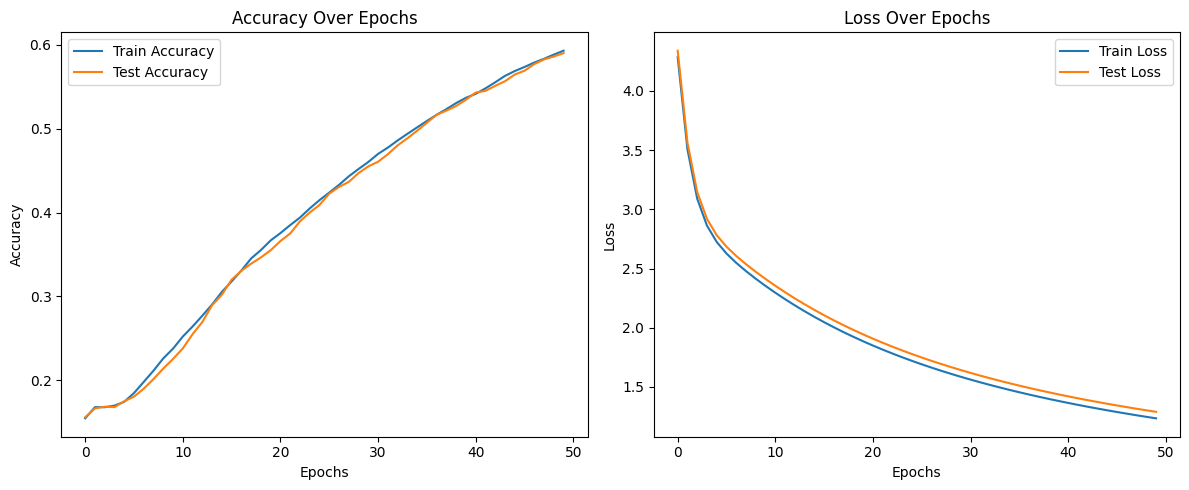

In [ ]:
# Plot the metrics
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/50, Train Accuracy: 0.2294, Test Accuracy: 0.2210, Train Loss: 8.2624, Test Loss: 8.5330
Epoch 2/50, Train Accuracy: 0.2685, Test Accuracy: 0.2635, Train Loss: 4.6305, Test Loss: 4.7895
Epoch 3/50, Train Accuracy: 0.2655, Test Accuracy: 0.2635, Train Loss: 3.3439, Test Loss: 3.4645
Epoch 4/50, Train Accuracy: 0.2626, Test Accuracy: 0.2655, Train Loss: 2.8038, Test Loss: 2.9195
Epoch 5/50, Train Accuracy: 0.2624, Test Accuracy: 0.2685, Train Loss: 2.5477, Test Loss: 2.6632
Epoch 6/50, Train Accuracy: 0.2647, Test Accuracy: 0.2710, Train Loss: 2.4054, Test Loss: 2.5136
Epoch 7/50, Train Accuracy: 0.2707, Test Accuracy: 0.2780, Train Loss: 2.3144, Test Loss: 2.4171
Epoch 8/50, Train Accuracy: 0.2818, Test Accuracy: 0.2905, Train Loss: 2.2506, Test Loss: 2.3508
Epoch 9/50, Train Accuracy: 0.2879, Test Accuracy: 0.2970, Train Loss: 2.2008, Test Loss: 2.2991
Epoch 10/50, Train Accuracy: 0.2951, Test Accuracy: 0.3060, Train Loss: 2.1606, Test Loss: 2.2573
Epoch 11/50, Train Accuracy: 

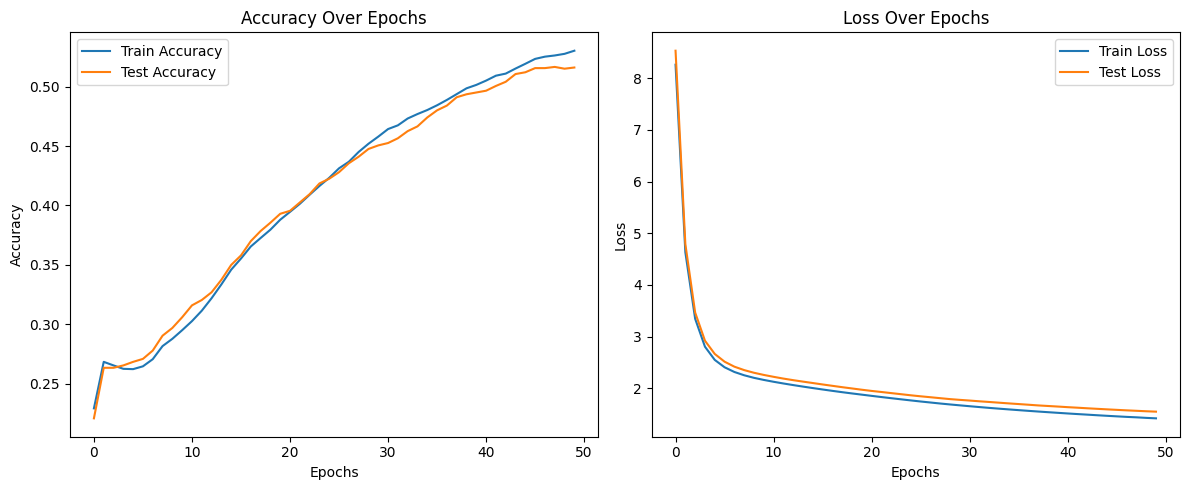

In [ ]:


# Determine the dimensions
input_dim = x_train.shape[1]
hidden_dims = [64, 32]  # Example hidden layer sizes
output_dim = len(np.unique(y_train))
init_range = 1

# Initialize weights and biases for multiple layers
weights = []
biases = []

layer_dims = [input_dim] + hidden_dims + [output_dim]

for i in range(len(layer_dims) - 1):
    w = np.random.uniform(-init_range, init_range, (layer_dims[i+1], layer_dims[i]))
    b = np.zeros((layer_dims[i+1], 1))
    weights.append(w)
    biases.append(b)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(z):
    return np.maximum(z, 0)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def forward_prop(x, weights, biases):
    activations = []
    zs = []

    a = x
    for w, b in zip(weights[:-1], biases[:-1]):
        z = w.dot(a) + b
        a = ReLU(z)
        zs.append(z)
        activations.append(a)

    z = weights[-1].dot(a) + biases[-1]
    a = softmax(z)
    zs.append(z)
    activations.append(a)

    return zs, activations

def deriv_ReLU(z):
    return z > 0

def one_hot(y, num_classes):
    one_hot_y = np.zeros((y.size, num_classes))
    one_hot_y[np.arange(y.size), y] = 1
    return one_hot_y.T

def back_prop(x, y, zs, activations, weights, l2_lambda):
    m = y.size
    one_hot_y = one_hot(y, activations[-1].shape[0])
    dz = activations[-1] - one_hot_y

    grads_w = []
    grads_b = []

    for i in reversed(range(len(weights))):
        dw = 1 / m * dz.dot(activations[i-1].T) if i != 0 else 1 / m * dz.dot(x.T)
        db = 1 / m * np.sum(dz, axis=1, keepdims=True)
        grads_w.insert(0, dw + (l2_lambda / m) * weights[i])
        grads_b.insert(0, db)

        if i != 0:
            da = weights[i].T.dot(dz)
            dz = da * deriv_ReLU(zs[i-1])

    return grads_w, grads_b

def update_params(weights, biases, grads_w, grads_b, learning_rate):
    for i in range(len(weights)):
        weights[i] -= learning_rate * grads_w[i]
        biases[i] -= learning_rate * grads_b[i]

def compute_loss(a2, y, weights, l2_lambda):
    m = y.size
    one_hot_y = one_hot(y, a2.shape[0])
    log_probs = -np.log(a2[one_hot_y == 1])
    data_loss = np.sum(log_probs) / m
    l2_loss = l2_lambda / (2 * m) * sum(np.sum(np.square(w)) for w in weights)
    return data_loss + l2_loss

def train_model(x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate, l2_lambda):
    num_classes = len(np.unique(y_train))
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        permutation = np.random.permutation(x_train.shape[0])
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train_shuffled[i:i+batch_size].T
            y_batch = y_train_shuffled[i:i+batch_size]

            zs, activations = forward_prop(x_batch, weights, biases)
            grads_w, grads_b = back_prop(x_batch, y_batch, zs, activations, weights, l2_lambda)
            update_params(weights, biases, grads_w, grads_b, learning_rate)

        # Training metrics
        zs, activations = forward_prop(x_train.T, weights, biases)
        train_predictions = np.argmax(activations[-1], axis=0)
        train_accuracy = np.mean(train_predictions == y_train)
        train_loss = compute_loss(activations[-1], y_train, weights, l2_lambda)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        # Validation metrics
        zs, activations = forward_prop(x_test.T, weights, biases)
        test_predictions = np.argmax(activations[-1], axis=0)
        test_accuracy = np.mean(test_predictions == y_test)
        test_loss = compute_loss(activations[-1], y_test, weights, l2_lambda)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_accuracies, test_accuracies, train_losses, test_losses

# Parameters
epochs = 50
batch_size = 32
learning_rate = 0.001
l2_lambda = 0.01

# Train the model and get the metrics
train_accuracies, test_accuracies, train_losses, test_losses = train_model(x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate, l2_lambda)

# Plot the metrics
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
